# Install Necessary Libraries

In [1]:
!pip install gradio scispacy datasets nltk
!pip install transformers faiss-cpu sentence-transformers scispacy
!pip install --no-deps https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_core_sci_sm-0.5.0.tar.gz
!pip install rouge-score

  Using cached gradio-5.8.0-py3-none-any.whl.metadata (16 kB)
  Using cached scispacy-0.5.5-py3-none-any.whl.metadata (18 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached fastapi-0.115.6-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.4.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-1.5.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached MarkupSafe-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.19-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.8.2-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.41.3-py3-none-any.whl.metadata (6.0 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.meta

# Mount Drive

In [8]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


# Define the base path in Google Drive
base_path = '/content/drive/My Drive/Project/410-Project-Submission'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [9]:
import json
import os
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import torch
from torch.utils.data import Dataset, DataLoader

nltk.download('stopwords')
nltk.download('wordnet')

class BioASQProcessor:
    def __init__(self, bioasq_path):
        self.punctuations = '"\,<>./?@#$%^&*_~/!()-[]{};:\''
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.bioasq_path = bioasq_path
        self.dataset = self.load_dataset()
        self.info = self.collect_info()

    def load_dataset(self):
        # Load BioASQ dataset
        with open(self.bioasq_path, 'r') as file:
            return json.load(file)

    def preprocess_text(self, text):
        # Lowercase and remove HTML
        text = text.lower().strip()
        if '<' in text:
            text = text.split('<')[0]
        if '>' in text:
            text = text.split('>')[-1]

        # Remove punctuation, tokenize, remove stopwords, and lemmatize
        clean_text = ''.join(char for char in text if char not in self.punctuations and not char.isdigit())
        words = clean_text.split()
        clean_words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]

        return ' '.join(clean_words)

    def preprocess_data(self):
        # Preprocess questions, snippets, and answers in each entry
        for entry in self.dataset['questions']:
            entry['body'] = self.preprocess_text(entry['body'])
            for snippet in entry['snippets']:
                snippet['text'] = self.preprocess_text(snippet['text'])
            if 'ideal_answer' in entry:
                entry['ideal_answer'] = [self.preprocess_text(ans) for ans in entry['ideal_answer']]
            if 'concepts' in entry:
                entry['concepts'] = [self.preprocess_text(con) for con in entry['concepts']]
        return self.dataset

    def collect_info(self):
        # Extract and display information about the dataset
        num_entries = len(self.dataset['questions'])
        dataset_size = os.path.getsize(self.bioasq_path) / 1024  # Size in KB
        vocab = set()

        for entry in self.dataset['questions']:
            vocab.update(entry['body'].split())
            for snippet in entry['snippets']:
                vocab.update(snippet['text'].split())
            if 'ideal_answer' in entry:
                for ans in entry['ideal_answer']:
                    vocab.update(ans.split())
            if 'concepts' in entry:
                vocab.update(entry['concepts'])

        return {
            'num_entries': num_entries,
            'dataset_size_kb': dataset_size,
            'vocab_size': len(vocab),
            'avg_words_per_entry': sum(len(entry['body'].split()) + sum(len(snippet['text'].split()) for snippet in entry['snippets']) for entry in self.dataset['questions']) / num_entries,
        }

# Process BioASQ Data
bioasq_processor = BioASQProcessor(base_path+'/BioASQ-training12b/training12b_new.json')
preprocessed_data = bioasq_processor.preprocess_data()
info = bioasq_processor.info
print("Dataset Info:", info)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Info: {'num_entries': 5049, 'dataset_size_kb': 38994.5361328125, 'vocab_size': 138371, 'avg_words_per_entry': 348.4848484848485}


# Extract Bio medical Corpus

In [11]:
import pandas as pd
corpus_save_path = os.path.join(base_path, 'biomedical_corpus.json')

# =========================================
# 3. Load Dataset and Prepare Corpus
# =========================================

if os.path.exists(corpus_save_path):
    # Load the pre-saved corpus
    with open(corpus_save_path, 'r') as f:
        biomedical_corpus = json.load(f)
    print("Biomedical corpus loaded successfully.")
else:
    df = pd.json_normalize(preprocessed_data['questions'])

    # Extract all contexts/snippets into a corpus list
    def extract_corpus(dataframe):
        corpus = []
        for idx, row in dataframe.iterrows():
            snippets = row.get('snippets', [])
            for snippet in snippets:
                text = snippet.get('text', '')
                if text:
                    corpus.append(text)
        return corpus

    biomedical_corpus = extract_corpus(df)
    print(f"Total number of contexts in the corpus: {len(biomedical_corpus)}")

    # Save the corpus
    with open(corpus_save_path, 'w') as f:
        json.dump(biomedical_corpus, f)
    print(f"Biomedical corpus saved to {corpus_save_path}")

Total number of contexts in the corpus: 60078
Biomedical corpus saved to /content/drive/My Drive/Project/410-Project-Submission/biomedical_corpus.json


# Training

In [12]:
# Import Libraries
import json
import re
import pandas as pd
import numpy as np
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
import faiss
import scispacy
import spacy
from google.colab import drive
import gradio as gr
import os

faiss_index_path = os.path.join(base_path, 'faiss_index.bin')
embeddings_path = os.path.join(base_path, 'corpus_embeddings.npy')
gpt_model_save_path = os.path.join(base_path, 'gpt_model')


# =========================================
# 4. Initialize Models and Load/Save Resources
# =========================================

# Initialize Sentence Transformer
sentence_model = SentenceTransformer('allenai/scibert_scivocab_uncased')

if os.path.exists(embeddings_path):
    # Load precomputed embeddings
    corpus_embeddings = np.load(embeddings_path)
    print("Loaded precomputed embeddings.")
else:
    # Compute embeddings for the corpus
    print("Computing embeddings for the biomedical corpus...")
    corpus_embeddings = sentence_model.encode(biomedical_corpus, convert_to_tensor=False, show_progress_bar=True)
    # Save the embeddings
    np.save(embeddings_path, corpus_embeddings)
    print(f"Embeddings saved to {embeddings_path}")

# Initialize FAISS index
embedding_dim = sentence_model.get_sentence_embedding_dimension()
if os.path.exists(faiss_index_path):
    # Load pre-saved FAISS index
    faiss_index = faiss.read_index(faiss_index_path)
    print("Loaded FAISS index.")
else:
    # Create and populate the FAISS index
    faiss_index = faiss.IndexFlatL2(embedding_dim)
    faiss_index.add(corpus_embeddings)
    # Save the FAISS index
    faiss.write_index(faiss_index, faiss_index_path)
    print(f"FAISS index saved to {faiss_index_path}")

# Initialize GPT model and tokenizer
gpt_model_name = 'EleutherAI/gpt-neo-1.3B'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check and handle missing GPT model files
def verify_gpt_model_files(path):
    required_files = [
        "config.json",
        "generation_config.json",
        "special_tokens_map.json",
        "tokenizer.json",
        "tokenizer_config.json",
        "vocab.json",
        "pytorch_model.bin",
    ]
    missing_files = [file for file in required_files if not os.path.exists(os.path.join(path, file))]
    return missing_files

if os.path.exists(gpt_model_save_path):
    # Verify model files
    missing_files = verify_gpt_model_files(gpt_model_save_path)
    if missing_files:
        print(f"Missing files: {missing_files}")
        print("Re-downloading the GPT model...")
        try:
            gpt_model = AutoModelForCausalLM.from_pretrained(gpt_model_name).to(device)
            gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_name)
            gpt_model.save_pretrained(gpt_model_save_path)
            gpt_tokenizer.save_pretrained(gpt_model_save_path)
            print(f"GPT model and tokenizer saved to {gpt_model_save_path}")
        except Exception as e:
            print(f"Error saving the GPT model: {e}")
    else:
        # Load pre-saved GPT model
        try:
            gpt_model = AutoModelForCausalLM.from_pretrained(gpt_model_save_path).to(device)
            gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_save_path)
            print("Loaded GPT model and tokenizer.")
        except Exception as e:
            print(f"Error loading the GPT model: {e}")
else:
    print("GPT model not found. Downloading...")
    try:
        # Load and save the GPT model
        gpt_model = AutoModelForCausalLM.from_pretrained(gpt_model_name).to(device)
        gpt_tokenizer = AutoTokenizer.from_pretrained(gpt_model_name)
        gpt_model.save_pretrained(gpt_model_save_path)
        gpt_tokenizer.save_pretrained(gpt_model_save_path)
        print(f"GPT model and tokenizer saved to {gpt_model_save_path}")
    except Exception as e:
        print(f"Error downloading/saving the GPT model: {e}")

# Initialize NER pipeline
try:
    nlp_ner = spacy.load("en_core_sci_sm")
except:
    # If the model is not installed, install it
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
    nlp_ner = spacy.load("en_core_sci_sm")

ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", tokenizer="dslim/bert-base-NER", aggregation_strategy="simple")

# =========================================
# 5. Define Helper Functions
# =========================================

def extract_keywords(question):
    """
    Extracts keywords from the question using BERT NER.
    """
    ner_results = ner_pipeline(question)
    keywords = [entity['word'] for entity in ner_results]
    return keywords

def retrieve_context(keywords, top_k=3):
    """
    Retrieves top_k contexts from the corpus based on keyword similarity.
    """
    if not keywords:
        return []
    # Combine keywords into a single query
    query = ' '.join(keywords)
    # Compute embedding for the query
    query_embedding = sentence_model.encode([query], convert_to_tensor=False)
    # Search in FAISS index
    D, I = faiss_index.search(query_embedding, top_k)
    # Retrieve corresponding contexts
    retrieved_contexts = [biomedical_corpus[idx] for idx in I[0]]
    return retrieved_contexts

def generate_answer(question, contexts, max_length=200):
    """
    Generates an answer using GPT based on the question and retrieved contexts.
    """
    if not contexts:
        return "I'm sorry, I couldn't find relevant information to answer your question."

    # Combine contexts into a single string
    context_str = "\n".join(contexts)
    # Create the prompt for GPT
    prompt = f"Context: {context_str}\n\nQuestion: {question}\nAnswer:"
    inputs = gpt_tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate answer
    try:
        with torch.no_grad():
            outputs = gpt_model.generate(
                inputs,
                max_length=inputs.shape[1] + max_length,
                temperature=0.7,
                top_p=0.9,
                do_sample=True,
                num_return_sequences=1,
                eos_token_id=gpt_tokenizer.eos_token_id
            )

        # Decode the generated tokens
        answer = gpt_tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Extract the answer part
        answer = answer.split("Answer:")[-1].strip()
        return answer
    except Exception as e:
        print(f"Error generating answer: {e}")
        return "I'm sorry, I encountered an error while generating the answer."

# =========================================
# 6. Define Gradio Interface
# =========================================

def qa_system(question):
    if not question.strip():
        return "Please enter a valid biomedical question."

    # Step 1: Extract Keywords
    keywords = extract_keywords(question)
    if not keywords:
        return "Couldn't extract any keywords from the question."

    # Step 2: Retrieve Contexts
    contexts = retrieve_context(keywords, top_k=3)
    if not contexts:
        return "Couldn't retrieve relevant contexts for the question."

    # Step 3: Generate Answer
    answer = generate_answer(question, contexts)
    return answer

iface = gr.Interface(
    fn=qa_system,
    inputs=gr.Textbox(lines=2, placeholder="Enter your biomedical question here.", label="Question"),
    outputs=gr.Textbox(label="Answer"),
    title="DocBot: Biomedical QA Assistant",
    description="Ask biomedical questions and receive accurate answers powered by a hybrid BERT",
    examples=[
        ["Is Hirschsprung disease a mendelian or a multifactorial disorder?"],
        ["How does CRISPR-Cas9 work?"]
    ]
)

iface.launch(share=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Loaded precomputed embeddings.
Loaded FAISS index.
Missing files: ['pytorch_model.bin']
Re-downloading the GPT model...


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

GPT model and tokenizer saved to /content/drive/My Drive/Project/410-Project-Submission/gpt_model


/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_sm' (0.5.0) was trained with spaCy v3.2.3 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9985a812be2fb5c009.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Evaluation

In [ ]:
import glob

# Define the test files path
test_files_path = base_path+'/Task12BGoldenEnriched/*.json'

# Load all JSON test files
test_files = glob.glob(test_files_path)

test_data = []
for file in test_files:
    with open(file, 'r') as f:
        test_data.extend(json.load(f)['questions'])  # Assuming each file contains a 'questions' key
print(f"Loaded {len(test_data)} questions from {len(test_files)} test files.")

Loaded 340 questions from 4 test files.


In [ ]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_model(test_questions):
    results = {
        'ROUGE-1': [],
        'ROUGE-2': [],
        'ROUGE-L': [],
        'F1': []
    }

    for question in test_questions:
        # Get the gold answer (handles list or string formats)
        gold_answer = question.get('exact_answer', "")
        if isinstance(gold_answer, list):
            gold_answer = " ".join(" ".join(a) if isinstance(a, list) else a for a in gold_answer)

        if not gold_answer.strip():
            continue  # Skip questions without an exact answer

        # Generate the answer using your QA system
        generated_answer = qa_system(question['body'])

        # ROUGE scores
        rouge_scores = scorer.score(gold_answer, generated_answer)
        results['ROUGE-1'].append(rouge_scores['rouge1'].fmeasure)
        results['ROUGE-2'].append(rouge_scores['rouge2'].fmeasure)
        results['ROUGE-L'].append(rouge_scores['rougeL'].fmeasure)

        # F1 score (simple token matching)
        gold_tokens = set(gold_answer.split())
        generated_tokens = set(generated_answer.split())
        common_tokens = gold_tokens & generated_tokens

        precision = len(common_tokens) / len(generated_tokens) if generated_tokens else 0
        recall = len(common_tokens) / len(gold_tokens) if gold_tokens else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        results['F1'].append(f1)

    return results

evaluation_results = evaluate_model(test_data)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask an

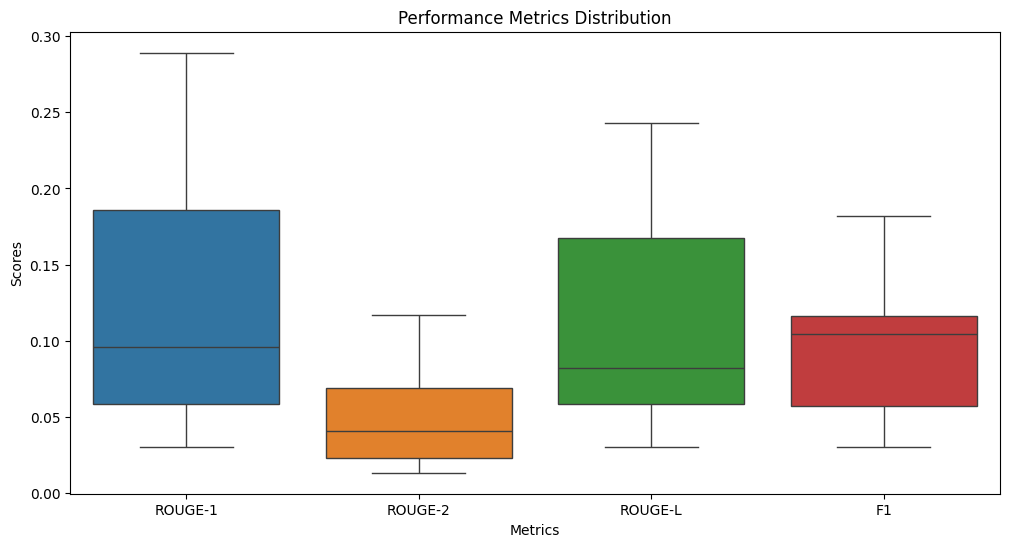

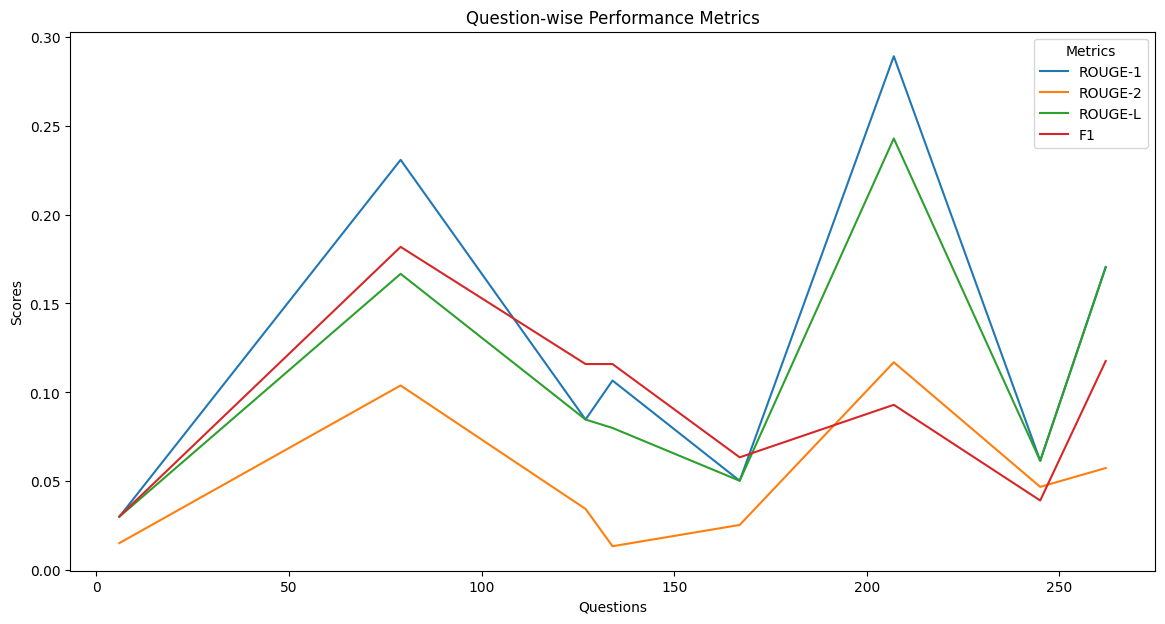

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to a DataFrame
evaluation_df = pd.DataFrame({
    'ROUGE-1': evaluation_results['ROUGE-1'],
    'ROUGE-2': evaluation_results['ROUGE-2'],
    'ROUGE-L': evaluation_results['ROUGE-L'],
    'F1': evaluation_results['F1']
})

# Remove rows with zero values in any column
evaluation_df = evaluation_df.loc[(evaluation_df != 0).all(axis=1)]

# Boxplot for metrics
plt.figure(figsize=(12, 6))
sns.boxplot(data=evaluation_df)
plt.title('Performance Metrics Distribution')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()

# Lineplot for question-wise scores
plt.figure(figsize=(14, 7))
sns.lineplot(data=evaluation_df, dashes=False)
plt.title('Question-wise Performance Metrics')
plt.ylabel('Scores')
plt.xlabel('Questions')
plt.legend(title='Metrics')
plt.show()
